In [92]:
import random, itertools
from collections import defaultdict
import time

In [95]:
from IPython.display import clear_output

In [93]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys


if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from cliff_walking import CliffWalkingEnv
import plotting
import random

matplotlib.style.use('ggplot')

In [251]:
env = gym.envs.toy_text.TaxiEnv()

In [18]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation, h):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation][:, h])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [19]:
def make_exploitation_policy(Q, epsilon, nA):
    def policy_fn(observation, h):
        A = np.zeros(nA)
        best_action = np.argmax(Q[observation][:, h])
        A[best_action] = 1
        return A
    return policy_fn 

In [35]:
def make_epsilon_greedy_policy1(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

def make_exploitation_policy1(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.zeros(nA)
        best_action = np.argmax(Q[observation])
        A[best_action] = 1
        return A
    return policy_fn 

In [20]:
def q_learning(env, num_episodes, make_policy, bonus = 0, Q = None, discount_factor=1.0, alpha=0.5, epsilon=0.1, p = 0.1, H=500, c=0.0001):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    S = env.observation_space.n
    A = env.action_space.n
    T = H * num_episodes
    Q = Q or defaultdict(lambda: np.zeros((env.action_space.n, H + 1)))
    N = defaultdict(lambda: np.zeros((env.action_space.n, H + 1)))
    i = np.log(S*A*T/p)
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_policy(Q, epsilon, env.action_space.n)
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        env.reset()
        state = random.randint(0,S)
        # One step in the environment
        # total_reward = 0.0
        for h in range(H):
            
            # Take a step
            action_probs = policy(state, h)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = h
            
            
            # Table Update
            
            N[state][action, h] += 1
            t = N[state][action, h]
            bonus_value = c * np.sqrt(H /t)
            alpha = (H+1)/(H+t)
            best_next_action = np.argmax(Q[next_state][:, h+1])  
            target = reward + 0.01 * np.random.randn() + Q[next_state][best_next_action, h+1] + bonus*bonus_value
            delta = target - Q[state][action, h]
            Q[state][action, h] += alpha * delta
            t += 1
            if done or h == H:
                break
                
            state = next_state
    return Q, stats

In [29]:
import itertools

In [42]:
def q1_learning(env, num_episodes, make_policy, bonus = 0, noise = 0, Q = None, discount_factor=1.0, alpha=0.5, epsilon=0.1, p = 0.1, H=500, c=0.0001):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    S = env.observation_space.n
    A = env.action_space.n
    T = H * num_episodes
    Q = Q or defaultdict(lambda: np.zeros((env.action_space.n)))
    N = defaultdict(lambda: np.zeros((env.action_space.n)))
    i = np.log(S*A*T/p)
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_policy(Q, epsilon, env.action_space.n)
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        env.reset()
        state = random.randint(0,S)
        # One step in the environment
        # total_reward = 0.0
        for h in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = h
            
            
            # Table Update
            
            N[state][action] += 1
            t = N[state][action]
            bonus_value = c * np.sqrt(H /t)
            alpha = (H+1)/(H+t)
            best_next_action = np.argmax(Q[next_state])  
            target = reward + noise * 2 * np.random.randn() + Q[next_state][best_next_action] + bonus*bonus_value
            delta = target - Q[state][action]
            Q[state][action] += alpha * delta
            t += 1
            if done:
                break
                
            state = next_state
    return Q, stats

In [21]:
def q_eps_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state

    return Q, stats

In [22]:
from collections import deque
import math

In [23]:
class QCartPoleSolver():
    def __init__(self, buckets=(1, 1, 6, 12,), n_episodes=1000, n_win_ticks=195, min_alpha=0.1, min_epsilon=0.1, gamma=1.0, ada_divisor=25, max_env_steps=None, quiet=False, monitor=False):
        self.buckets = buckets # down-scaling feature space to discrete range
        self.n_episodes = n_episodes # training episodes 
        self.n_win_ticks = n_win_ticks # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha # learning rate
        self.min_epsilon = min_epsilon # exploration rate
        self.gamma = gamma # discount factor
        self.ada_divisor = ada_divisor # only for development purposes
        self.quiet = quiet

        self.env = gym.make('CartPole-v0')
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps
        if monitor: self.env = gym.wrappers.Monitor(self.env, 'tmp/cartpole-1', force=True) # record results for upload

        self.Q = np.zeros(self.buckets + (self.env.action_space.n,))

    def discretize(self, obs):
        upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50)]
        lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50)]
        ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return tuple(new_obs)

    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.Q[state])

    def update_q(self, state_old, action, reward, state_new, alpha):
        self.Q[state_old][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])

    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1, 1.0 - math.log10((t + 1) / self.ada_divisor)))

    def get_alpha(self, t):
        return max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.ada_divisor)))

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            current_state = self.discretize(self.env.reset())

            alpha = self.get_alpha(e)
            epsilon = self.get_epsilon(e)
            done = False
            i = 0

            while not done:
                # self.env.render()
                action = self.choose_action(current_state, epsilon)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize(obs)
                self.update_q(current_state, action, reward, new_state, alpha)
                current_state = new_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e


solver = QCartPoleSolver()
solver.run()
# gym.upload('tmp/cartpole-1', api_key='')

[Episode 0] - Mean survival time over last 100 episodes was 12.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 32.01 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 145.75 ticks.
Ran 239 episodes. Solved after 139 trials ✔


139

In [24]:
env.render()

NameError: name 'env' is not defined

In [25]:
def visualize(env, Q)
    env.reset()
    rewards = []
    total_test_episodes = 10
    max_steps = 500
    for episode in range(total_test_episodes):
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        #print("****************************************************")
        #print("EPISODE ", episode)

        for step in range(max_steps):
            # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
            # env.render()
            # Take the action (index) that have the maximum expected future reward given that state
            action = np.argmax(Q_h[state])

            new_state, reward, done, info = env.step(action)

            total_rewards += reward

            time.sleep(0.01)
            clear_output(wait=True)
            env.render()

            if done:
                rewards.append(total_rewards)
                print ("Score", total_rewards)
                time.sleep(2)
                break
            state = new_state



    env.close()
    print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

SyntaxError: invalid syntax (<ipython-input-25-5ba083ec3582>, line 1)

In [88]:
envs = [gym.envs.toy_text.TaxiEnv()]
policies = [make_epsilon_greedy_policy1, make_exploitation_policy1]
Q1 = dict()
stats1 = dict()
for environment in envs:
    Q1[environment] = dict()
    stats1[environment] = dict()
    for r in [0,1]:
        Q1[environment][r] = dict()
        stats1[environment][r] = dict()
        for policy in policies:
            if policy == make_exploitation_policy:
                Q1[environment][r][policy], stats1[environment][r][policy] = q1_learning(environment, 5000, policy, 1, r)
            else:
                Q1[environment][r][policy], stats1[environment][r][policy] = q1_learning(environment, 5000, policy, 0, r)
        


Episode 5000/5000.

In [2]:

solver.env.reset()
rewards = []
total_test_episodes = 10
max_steps = 500
for episode in range(total_test_episodes):
    state = solver.discretize(solver.env.reset())
    step = 0
    done = False
    total_rewards = 0
    #print("****************************************************")
    #print("EPISODE ", episode)

    for step in range(max_steps):
        # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
        # env.render()
        # Take the action (index) that have the maximum expected future reward given that state
        new_state, reward, done, info = solver.env.step(solver.choose_action(state, 0.1))

        total_rewards += reward

        time.sleep(0.01)
        clear_output(wait=True)
        solver.env.render()

        if done:
            rewards.append(total_rewards)
            print ("Score", total_rewards)
            time.sleep(2)
            break
        state = new_state



env.close()
print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

NameError: name 'solver' is not defined

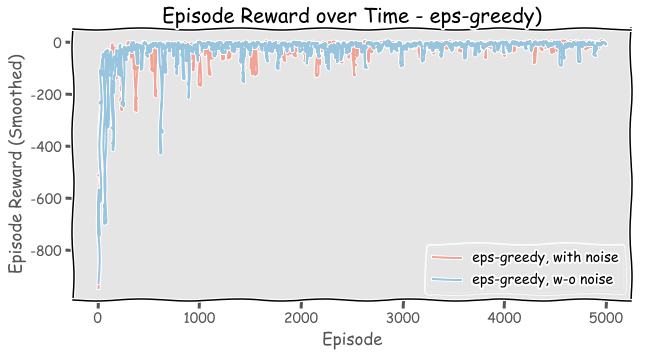

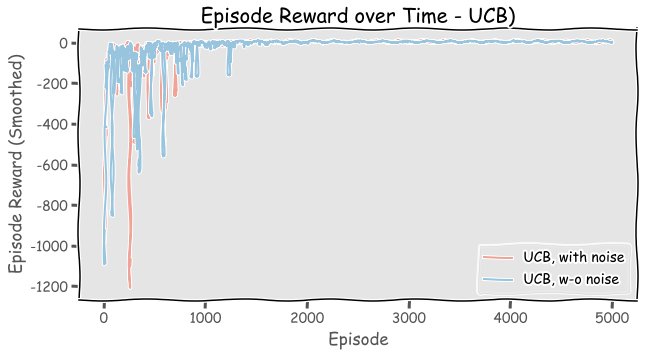

In [87]:
from matplotlib import pyplot as plt
with plt.xkcd():
    for env in envs:
        for i, policy in zip(['eps-greedy', 'UCB'],policies):
            fig = plt.figure(figsize=(10,5))
            for j, r in zip(['with noise', 'w-o noise'], [0,1]):
                rewards_smoothed = pd.Series(stats1[env][r][policy].episode_rewards).rolling(10, min_periods=10).mean()
                plt.plot(rewards_smoothed, alpha = 0.5, label = ('{}, {}'.format(i, j)))
            plt.xlabel("Episode")
            plt.ylabel("Episode Reward (Smoothed)")
            plt.legend()
            plt.title("Episode Reward over Time - {})".format(i))
            plt.show(fig)
            fig.savefig('{}.pdf'.format(i))

In [97]:
env.reset()
rewards = []
total_test_episodes = 10
max_steps = 500
for env in envs:
    env.reset()
    rewards = []
    for p in policies: 
        for episode in range(total_test_episodes):
            state = env.reset()
            step = 0
            done = False
            total_rewards = 0
            #print("****************************************************")
            #print("EPISODE ", episode)

            for step in range(max_steps):
                # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
                # env.render()
                # Take the action (index) that have the maximum expected future reward given that state
                action = np.argmax(Q1[env][1][p][state])

                new_state, reward, done, info = env.step(action)

                total_rewards += reward

                time.sleep(2)
                clear_output(wait=True)
                env.render()

                if done:
                    rewards.append(total_rewards)
                    print ("Score", total_rewards)
                    time.sleep(2)
                    break
                state = new_state
    break


env.close()
print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Score 5
Score over time: 15.1
